In [2]:
import geopandas as gpd
import rioxarray as rxr
from rasterstats import zonal_stats
import pandas as pd
import os
import rasterio
from rasterio.mask import mask
import numpy as np
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

In [3]:
# laptop
folder = "../../_data/p-dengue/"
valid_admin2 = pd.read_csv(os.path.join(folder, 'valid_admin/valid_admin2.csv'), header=None)[0].tolist()
valid_admin1 = pd.read_csv(os.path.join(folder, 'valid_admin/valid_admin1.csv'), header=None)[0].tolist()
valid_admin2.sort()
valid_admin1.sort()

In [4]:
#### shape data
admin1_shp = gpd.read_file(os.path.join(folder,"shapefiles/admin1/admin1_38.shp"))
admin2_shp = gpd.read_file(os.path.join(folder,"shapefiles/admin2/admin2_38.shp"))

admin1_shp = admin1_shp[[(a in valid_admin1) for a in admin1_shp['admin1']]]
admin2_shp = admin2_shp[[(a in valid_admin2) for a in admin2_shp['admin2']]]

# Order by relevant 'admin1/2' column
admin1_shp = admin1_shp.sort_values("admin1").reset_index(drop=True)
admin2_shp = admin2_shp.sort_values("admin2").reset_index(drop=True)

#### Population raster
raster_pop = {year :  rxr.open_rasterio(os.path.join(folder, f'raster_pop/landscan-global-{year}.tif'), masked=True) for year in range(2015,2025)}

#### Urban raster (GHSL GHS-SMOD)
raster_urbanisation = rxr.open_rasterio(os.path.join(folder, 'raster_urbanisation/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V2_0.tif'), masked=True)

#### Surveillance raster (Ahyoung Lim et al. Nature Medicine)
raster_surveillance = rxr.open_rasterio(os.path.join(folder, 'raster_surveillance/Surveillance_map_wmean.tif'), masked=True)
# EPSG:4326
raster_surveillance = raster_surveillance.rio.write_crs("EPSG:4326")

In [6]:
# population has highest resolution, others will be aligned to it through downsampling

print('Population crs:', raster_pop[2015].rio.crs)

print('Population resolution:', raster_pop[2015].rio.resolution())
print('Urbanisation resolution:', raster_urbanisation.rio.reproject(raster_pop[2015].rio.crs).rio.resolution())
print('Surveillance resolution:', raster_surveillance.rio.reproject(raster_pop[2015].rio.crs).rio.resolution())

Population crs: EPSG:4326
Population resolution: (0.0083333333333333, -0.0083333333333333)
Urbanisation resolution: (0.009961733526091018, -0.009961733526091018)
Surveillance resolution: (0.04166666666662877, -0.04166666666665719)


In [7]:
#### buffer for preliminary raster cropping

admin1_shp_buffered = admin1_shp.copy()
admin1_shp_buffered["geometry"] = (admin1_shp_buffered.to_crs("EPSG:3857").buffer(20_000).to_crs("EPSG:4326"))
# admin2_shp_buffered = admin2_shp.copy()
# admin2_shp_buffered["geometry"] = (admin2_shp_buffered.to_crs("EPSG:3857").buffer(20_000).to_crs("EPSG:4326"))

In [8]:
# cropping bounds
region_bounds_buffered = admin1_shp_buffered.total_bounds

In [14]:
region_bounds_buffered

array([ 94.83153076, -11.18383745, 141.19906305,   6.25536226])

---

## Region population total

Difference from Andra's data might come because I calculated this separately and pop_raster and shapes have same alignment, but he calculated this with pop_raster aligned with the urbanisation raster.

In [ ]:
# shape files and population raster in same projection
print(raster_pop[2015].rio.crs)
print(admin1_shp.crs)

EPSG:4326
EPSG:4326


In [ ]:
admin1_records = []
admin2_records = []

for year in range(2015,2025):
    pop_crop = raster_pop[year].squeeze().rio.clip_box(minx=region_bounds_buffered[0], miny=region_bounds_buffered[1],
                                                   maxx=region_bounds_buffered[2], maxy=region_bounds_buffered[3])
    admin1_pop_stats = zonal_stats(
        vectors=admin1_shp,
        raster=pop_crop.values,
        affine=pop_crop.rio.transform(),
        stats=["sum"],
        nodata=pop_crop.rio.nodata,
        all_touched=True)
    
    for i, row in enumerate(admin1_shp.itertuples()):
        admin1_records.append({
            "admin1": row.admin1,
            "year": year,
            "population": admin1_pop_stats[i]["sum"]
        })

    admin2_pop_stats = zonal_stats(
        vectors=admin2_shp,
        raster=pop_crop.values,
        affine=pop_crop.rio.transform(),
        stats=["sum"],
        nodata=pop_crop.rio.nodata,
        all_touched=True)
    
    for i, row in enumerate(admin2_shp.itertuples()):
        admin2_records.append({
            "admin2": row.admin2,
            "year": year,
            "population": admin2_pop_stats[i]["sum"]
        })

# Convert to DataFrames
df_admin1_pop = pd.DataFrame(admin1_records)
df_admin2_pop = pd.DataFrame(admin2_records)

# Optional: reset index
df_admin1_pop = df_admin1_pop.reset_index(drop=True)
df_admin2_pop = df_admin2_pop.reset_index(drop=True)

In [ ]:
out_folder = os.path.join(folder, "admin_year_pop")
os.makedirs(out_folder, exist_ok=True)

df_admin1_pop.to_csv(os.path.join(out_folder, "admin1_year_pop.csv"), index=False)
df_admin2_pop.to_csv(os.path.join(out_folder, "admin2_year_pop.csv"), index=False)

---

## Urbanisation

In [63]:
def align_r1_to_r2(
    r1,
    r2,
    data_type="categorical"   # "categorical" or "continuous"
):
    """
    Align raster r1 to the grid of raster r2.

    Parameters
    ----------
    r1 : xarray.DataArray
        Source raster to be aligned.
    r2 : xarray.DataArray
        Target raster defining CRS, resolution, extent, and grid.
    data_type : str
        "categorical" or "continuous".
    clip : bool
        If True, crop r1 to r2 extent before resampling.

    Returns
    -------
    xarray.DataArray
        r1 aligned to r2 grid.
    """
    
    # 3. Choose resampling method
    if data_type == "categorical":
        resampling = Resampling.nearest
    elif data_type == "continuous":
        resampling = Resampling.bilinear
    else:
        raise ValueError("data_type must be 'categorical' or 'continuous'")

    # 4. Resample onto r2 grid
    r1_aligned = r1.rio.reproject_match(
        r2,
        resampling=resampling
    )

    return r1_aligned, r2


In [64]:
def best_res_align(r1, r1catcon, r2, r2catcon,
                   region_bounds_buffered = region_bounds_buffered,
                   shape_crs = admin1_shp.crs):
    """
    Align the raster with lower resolution to the raster with higher resolution.

    Parameters
    ----------
    r1 : xarray.DataArray
        First raster.
    r1catcon : str
        "categorical" or "continuous" for r1.
    r2 : xarray.DataArray
        Second raster.
    r2catcon : str
        "categorical" or "continuous" for r2.

    Returns
    -------
    aligned_r1 : xarray.DataArray
        r1 aligned to the higher-resolution raster grid (r2 or r1 swapped if needed).
    target_raster : xarray.DataArray
        The raster whose grid is being used as the reference.
    """

    # 1. CRS check / reproject if needed
    if r1.rio.crs != shape_crs:
        r1 = r1.rio.reproject(shape_crs)
    if r2.rio.crs != shape_crs:
        r2 = r2.rio.reproject(shape_crs)
    
    r1 = r1.squeeze().rio.clip_box(minx=region_bounds_buffered[0], miny=region_bounds_buffered[1],
                                                   maxx=region_bounds_buffered[2], maxy=region_bounds_buffered[3])
    r2 = r2.squeeze().rio.clip_box(minx=region_bounds_buffered[0], miny=region_bounds_buffered[1],
                                                   maxx=region_bounds_buffered[2], maxy=region_bounds_buffered[3])

    # 2. Compare resolutions
    res_r1_x, res_r1_y = r1.rio.resolution()
    print('r1 resolution:', res_r1_x, res_r1_y)
    res_r2_x, res_r2_y = r2.rio.resolution()
    print('r2 resolution:', res_r2_x, res_r2_y)

    # Use the smaller cell size as the target (higher-resolution raster)
    r1_avg_res = (abs(res_r1_x) + abs(res_r1_y)) / 2
    r2_avg_res = (abs(res_r2_x) + abs(res_r2_y)) / 2

    if r1_avg_res > r2_avg_res:
        print('r1 is lower resolution, downsampling r1 to r2')
        # r1 is coarser -> align r1 to r2
        return align_r1_to_r2(r1, r2, data_type=r1catcon)
    else:
        print('r2 is lower resolution, downsampling r2 to r1')
        # r2 is coarser -> align r2 to r1
        return align_r1_to_r2(r2, r1, data_type=r2catcon)[::-1]


In [9]:
from data_utils import best_res_align

In [10]:
raster_pop_up_aligned = {}
raster_pop_up_aligned[2015], raster_urbanisation_up_aligned = best_res_align(raster_pop[2015], '',
                                                                       raster_urbanisation, 'categorical',
                                                                       region_bounds_buffered = region_bounds_buffered,
                                                                       shape_crs = admin1_shp.crs)

r1 resolution: 0.008333333333333304 -0.008333333333333297
r2 resolution: 0.009961733526091017 -0.009961733526091015
r2 is lower resolution, downsampling r2 to r1


In [12]:
raster_surveillance_us_aligned, raster_urbanisation_us_aligned = best_res_align(raster_surveillance, 'continuous',
                                                                       raster_urbanisation, 'categorical',
                                                                       region_bounds_buffered = region_bounds_buffered,
                                                                       shape_crs = admin1_shp.crs)

r1 resolution: 0.04166666666662877 -0.04166666666665719
r2 resolution: 0.009961733526091017 -0.009961733526091015
r1 is lower resolution, downsampling r1 to r2


In [43]:
raster_pop_up_aligned[2015]

<xarray.DataArray (y: 2094, x: 5565)> Size: 93MB
[11653110 values with dtype=float64]
Coordinates:
  * y            (y) float64 17kB 6.254 6.246 6.237 ... -11.17 -11.18 -11.19
  * x            (x) float64 45kB 94.83 94.84 94.85 94.85 ... 141.2 141.2 141.2
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

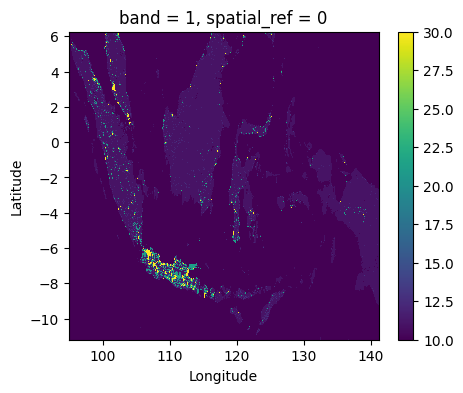

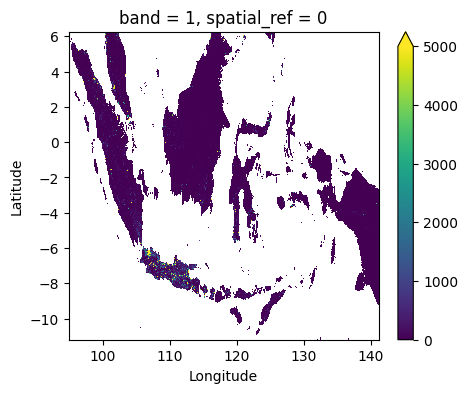

In [13]:
plt.figure(figsize=(5,4))
raster_urbanisation_up_aligned.squeeze().plot(
    cmap="viridis",       # color map  # colorbar label
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(5,4))
raster_pop_up_aligned[2015].squeeze().plot(
    cmap="viridis",       # color map  # colorbar label
    vmin=0, vmax=5000     # optional: set limits to avoid outliers dominating
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

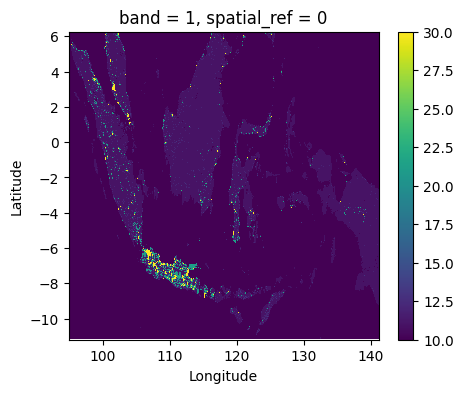

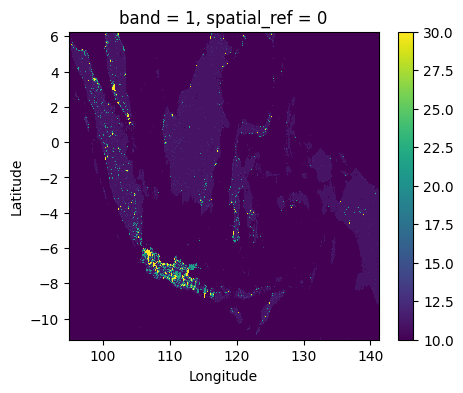

In [34]:
_, raster_urbanisation_a2_pop = align_r1_to_r2(raster_urbanisation, raster_pop[2015])

plt.figure(figsize=(5,4))
raster_urbanisation_a2_pop.squeeze().plot(
    cmap="viridis",       # color map  # colorbar label
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

minx, miny, maxx, maxy = raster_urbanisation_a2_pop.rio.bounds()
raster_urbanisation_plot = raster_urbanisation.copy()
if raster_urbanisation_plot.rio.crs != raster_urbanisation_a2_pop.rio.crs:
    raster_urbanisation_plot = raster_urbanisation_plot.rio.reproject(raster_urbanisation_a2_pop.rio.crs) 
raster_urbanisation_plot = raster_urbanisation_plot.squeeze().rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

plt.figure(figsize=(5,4))
raster_urbanisation_plot.squeeze().plot(
    cmap="viridis",       # color map  # colorbar label
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()